In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd
os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")

In [25]:
adata = sc.read_h5ad("cluster_files/adata_RKO_balanced.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 4080 × 14701
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc', 'n_genes'
    var: 'n_cells'
    layers: 'counts'


In [26]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0,0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print("Sorted Drug concentrations",adata.obs["drugconc_ordered"].unique())

[0.   0.05 0.5  5.  ]
Sorted Drug concentrations [0.00, 0.05, 0.50, 5.00]
Categories (4, float64): [0.00 < 0.05 < 0.50 < 5.00]


In [27]:
# Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, subset=True)
#sc.pp.scale(adata, max_value=10)

In [28]:
# PCA and neighbors
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

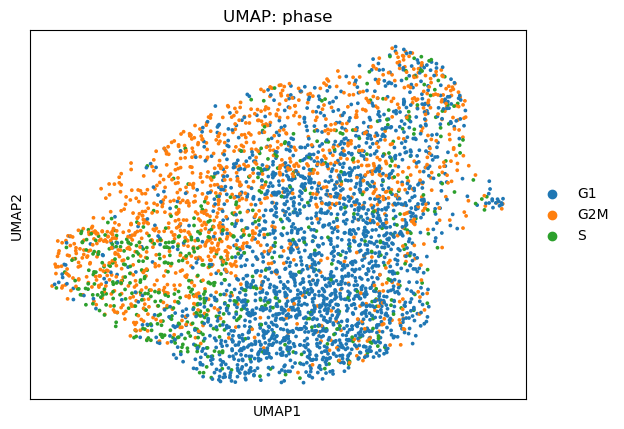

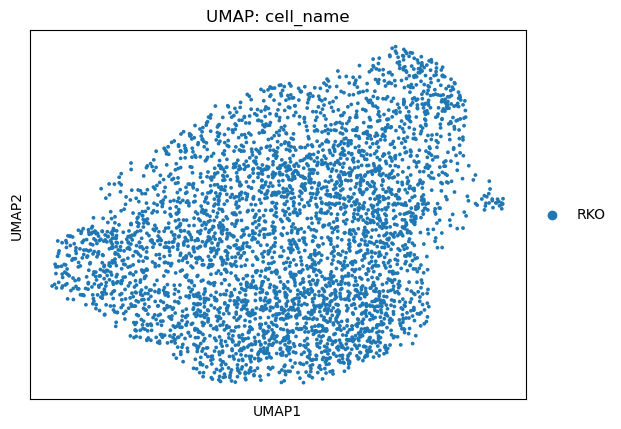

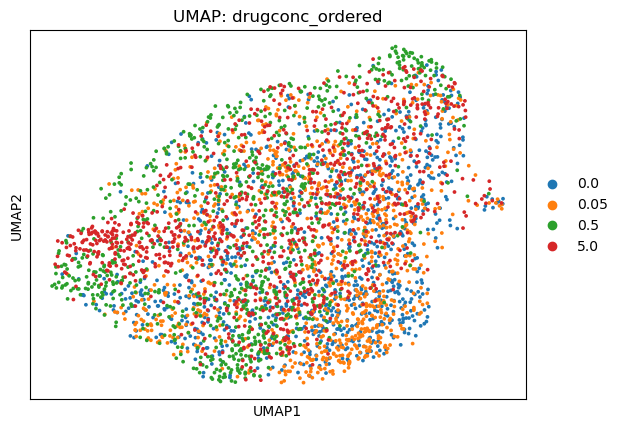

In [29]:
# UMAP plots
sc.pl.umap(adata, color=["phase"], title="UMAP: phase")
sc.pl.umap(adata, color=["cell_name"], title="UMAP: cell_name")
sc.pl.umap(adata, color=["drugconc_ordered"], title="UMAP: drugconc_ordered")


Cluster sizes:
 leiden_2
0    5327
1    5285
Name: count, dtype: int64


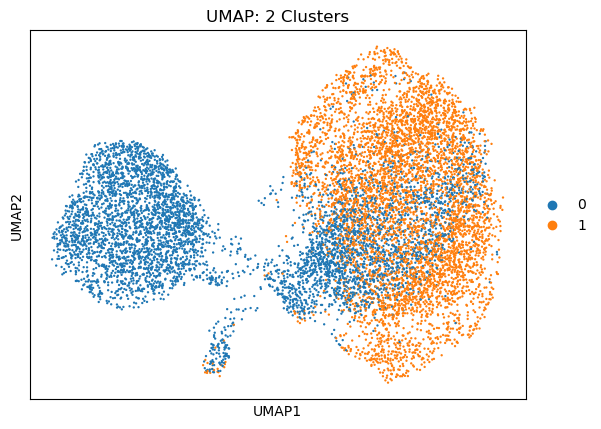

In [23]:
# Compute neighbors and run Leiden clustering with resolution tuned for 2 clusters
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X")  # or use_rep="X_pca" if PCA is available
sc.tl.leiden(adata, resolution=0.3, key_added="leiden_2")

# Confirm number of clusters
print("Cluster sizes:\n", adata.obs["leiden_2"].value_counts())

# Optional: visualize
sc.pl.umap(adata, color="leiden_2", title="UMAP: 2 Clusters")


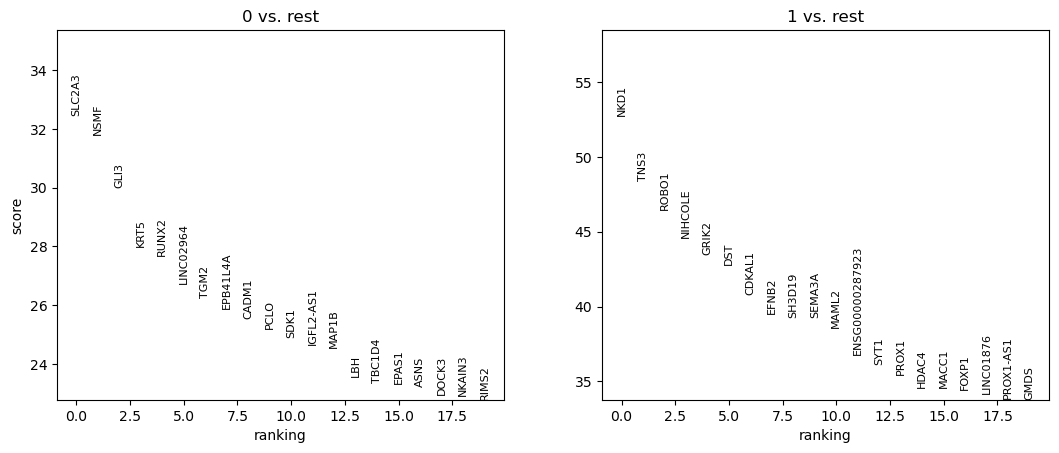

In [24]:
# Perform DE between the two clusters
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_2",
    method="t-test",
    use_raw=True,
    key_added="rank_genes_leiden2"
)

# Plot top differentially expressed genes
sc.pl.rank_genes_groups(adata, key="rank_genes_leiden2", n_genes=20, sharey=False)

In [ ]:
de_result = sc.get.rank_genes_groups_df(adata, key="rank_genes_leiden2", group='0')
print(de_result.head())

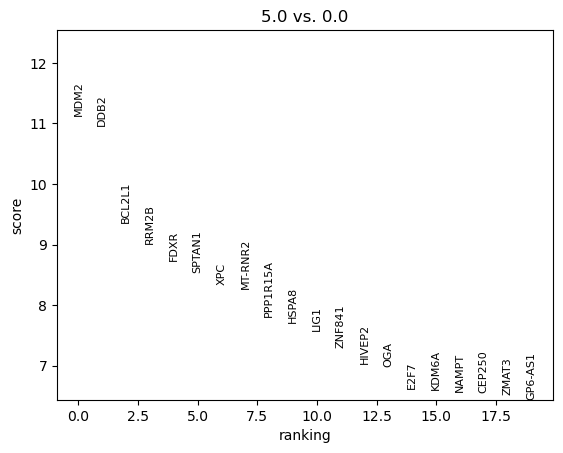

In [32]:
import scanpy as sc
import pandas as pd

# Subset to just drugconc 0 and 5.0
adata_sub = adata[adata.obs["drugconc_ordered"].isin([0.0, 5.0])].copy()

# Convert to categorical with correct order
adata_sub.obs["drugconc_ordered"] = adata_sub.obs["drugconc_ordered"].astype("category")
adata_sub.obs["drugconc_ordered"] = adata_sub.obs["drugconc_ordered"].cat.reorder_categories([0.0, 5.0], ordered=True)

# Run DE test (t-test, fast)
sc.tl.rank_genes_groups(adata_sub, groupby="drugconc_ordered", reference=0.0, method="t-test", use_raw=False)

# Plot top DE genes
sc.pl.rank_genes_groups(adata_sub, n_genes=20, sharey=False)

# Extract DE table
result = adata_sub.uns["rank_genes_groups"]
groups = result["names"].dtype.names
de_df = pd.DataFrame({
    'gene': result["names"][groups[0]],
    'logfc': result["logfoldchanges"][groups[0]],
    'pval': result["pvals"][groups[0]],
    'pval_adj': result["pvals_adj"][groups[0]]
})


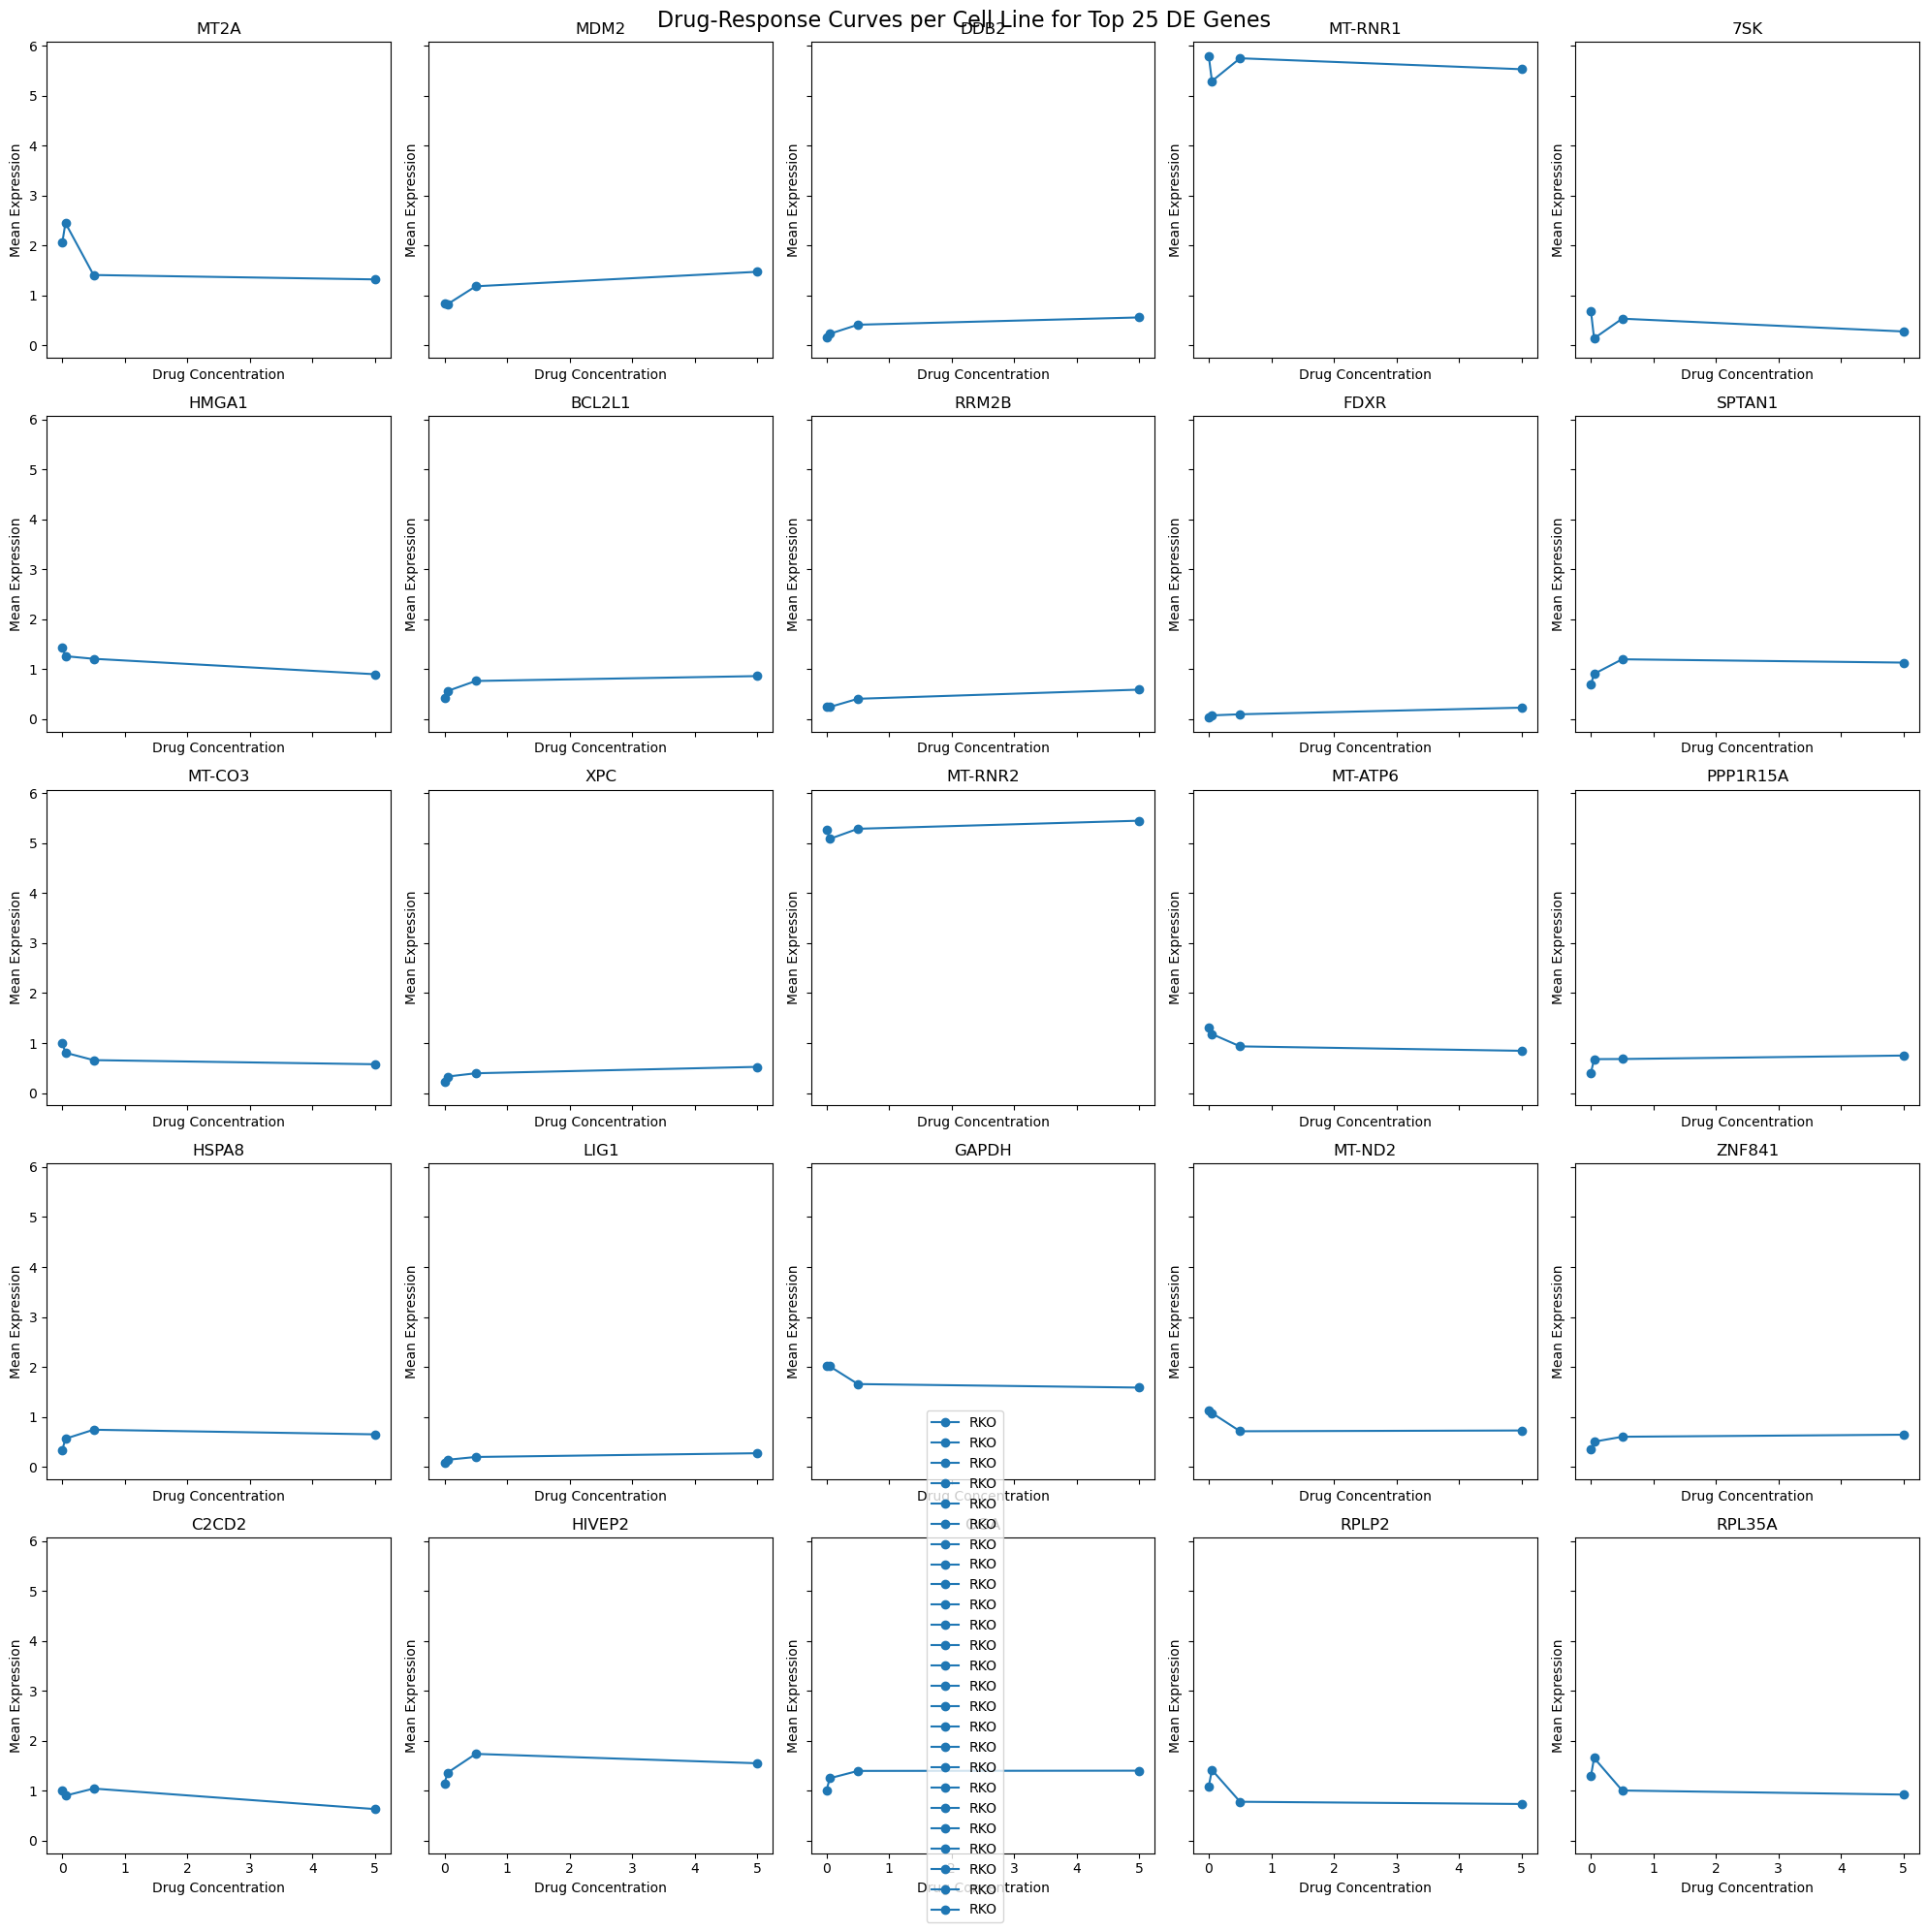

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Get top 25 genes by adjusted p-value
top_genes = de_df.nsmallest(25, 'pval_adj')['gene'].values

concentrations = sorted(adata.obs["drugconc"].unique())
cell_lines = adata.obs["cell_name"].unique()

# Create plot
fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=True)

for ax, gene in zip(axs.ravel(), top_genes):
    for cell_line in cell_lines:
        means = []
        for conc in concentrations:
            mask = (adata.obs["drugconc"] == conc) & (adata.obs["cell_name"] == cell_line)
            expr = adata[mask, gene].X
            mean_expr = np.asarray(expr.mean()).item() if expr.shape[0] > 0 else np.nan
            means.append(mean_expr)
        
        ax.plot(concentrations, means, marker='o', label=cell_line)

    ax.set_title(gene)
    ax.set_xlabel("Drug Concentration")
    ax.set_ylabel("Mean Expression")

fig.suptitle("Drug-Response Curves per Cell Line for Top 25 DE Genes", fontsize=16)
fig.tight_layout()
fig.legend(loc='lower center', ncol=len(cell_lines), bbox_to_anchor=(0.5, -0.01))
plt.savefig("drug_response_curves_top25_by_cellline.png", dpi=300, bbox_inches="tight")
plt.show()


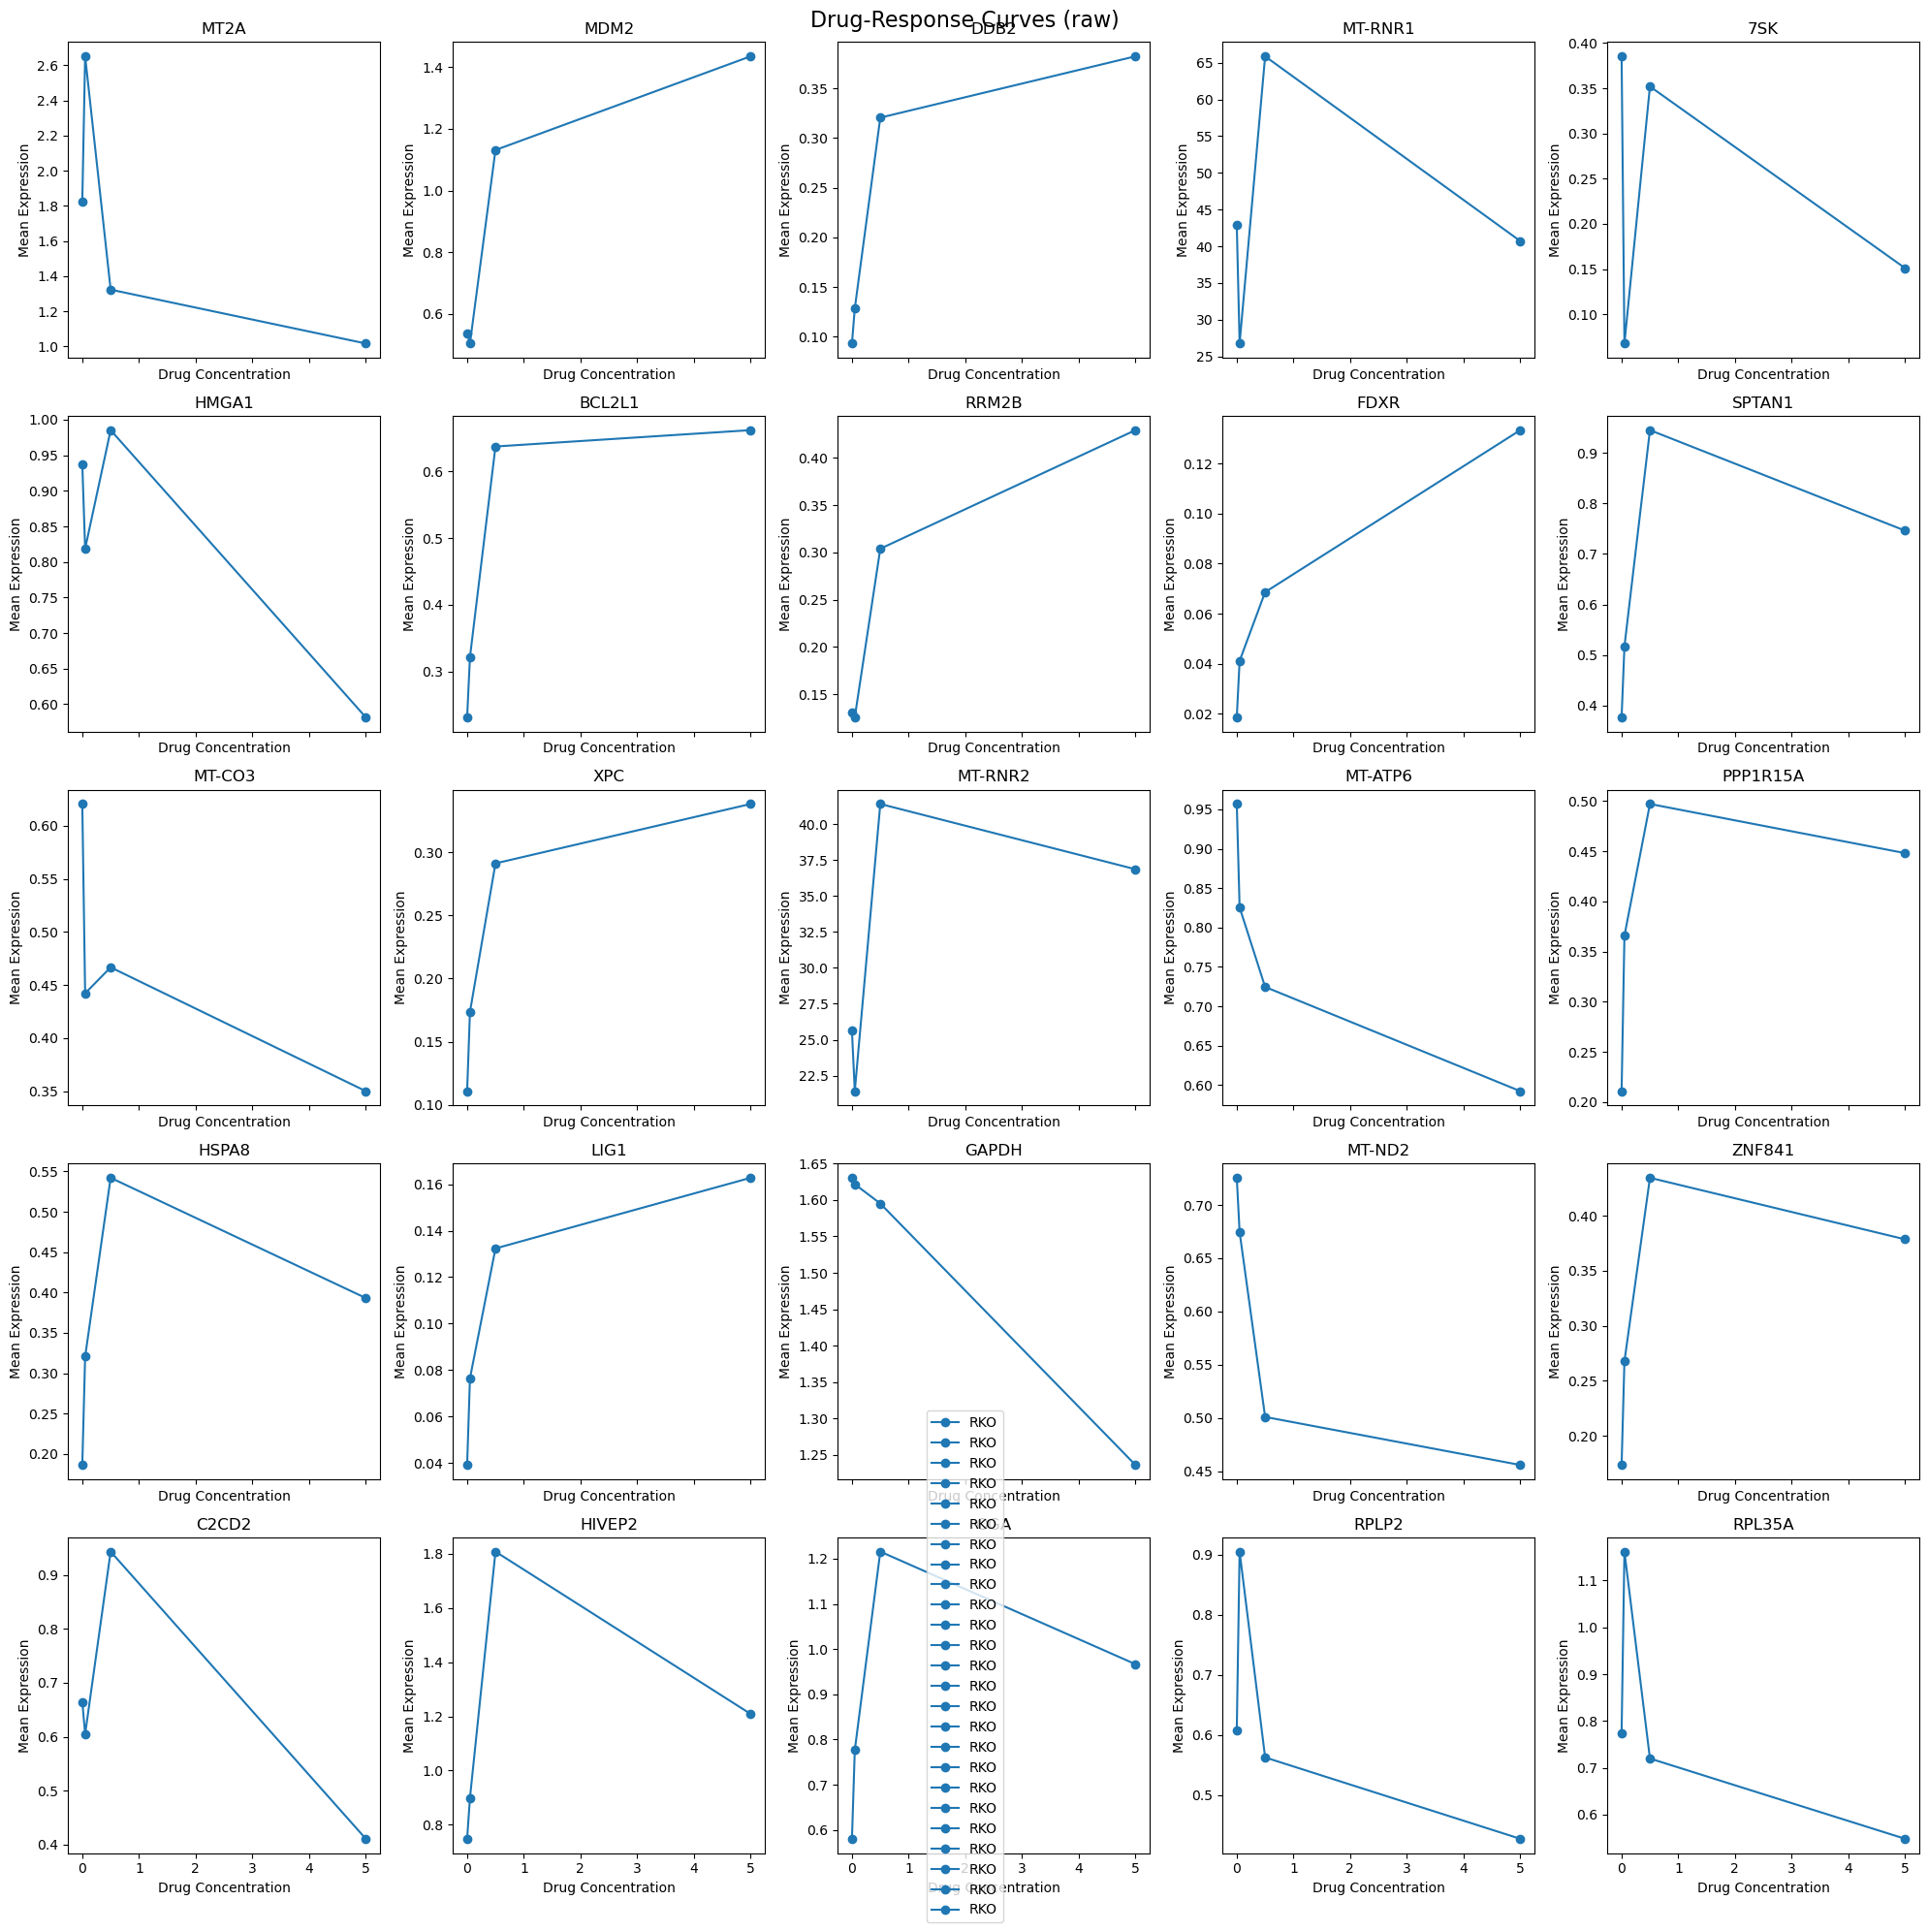

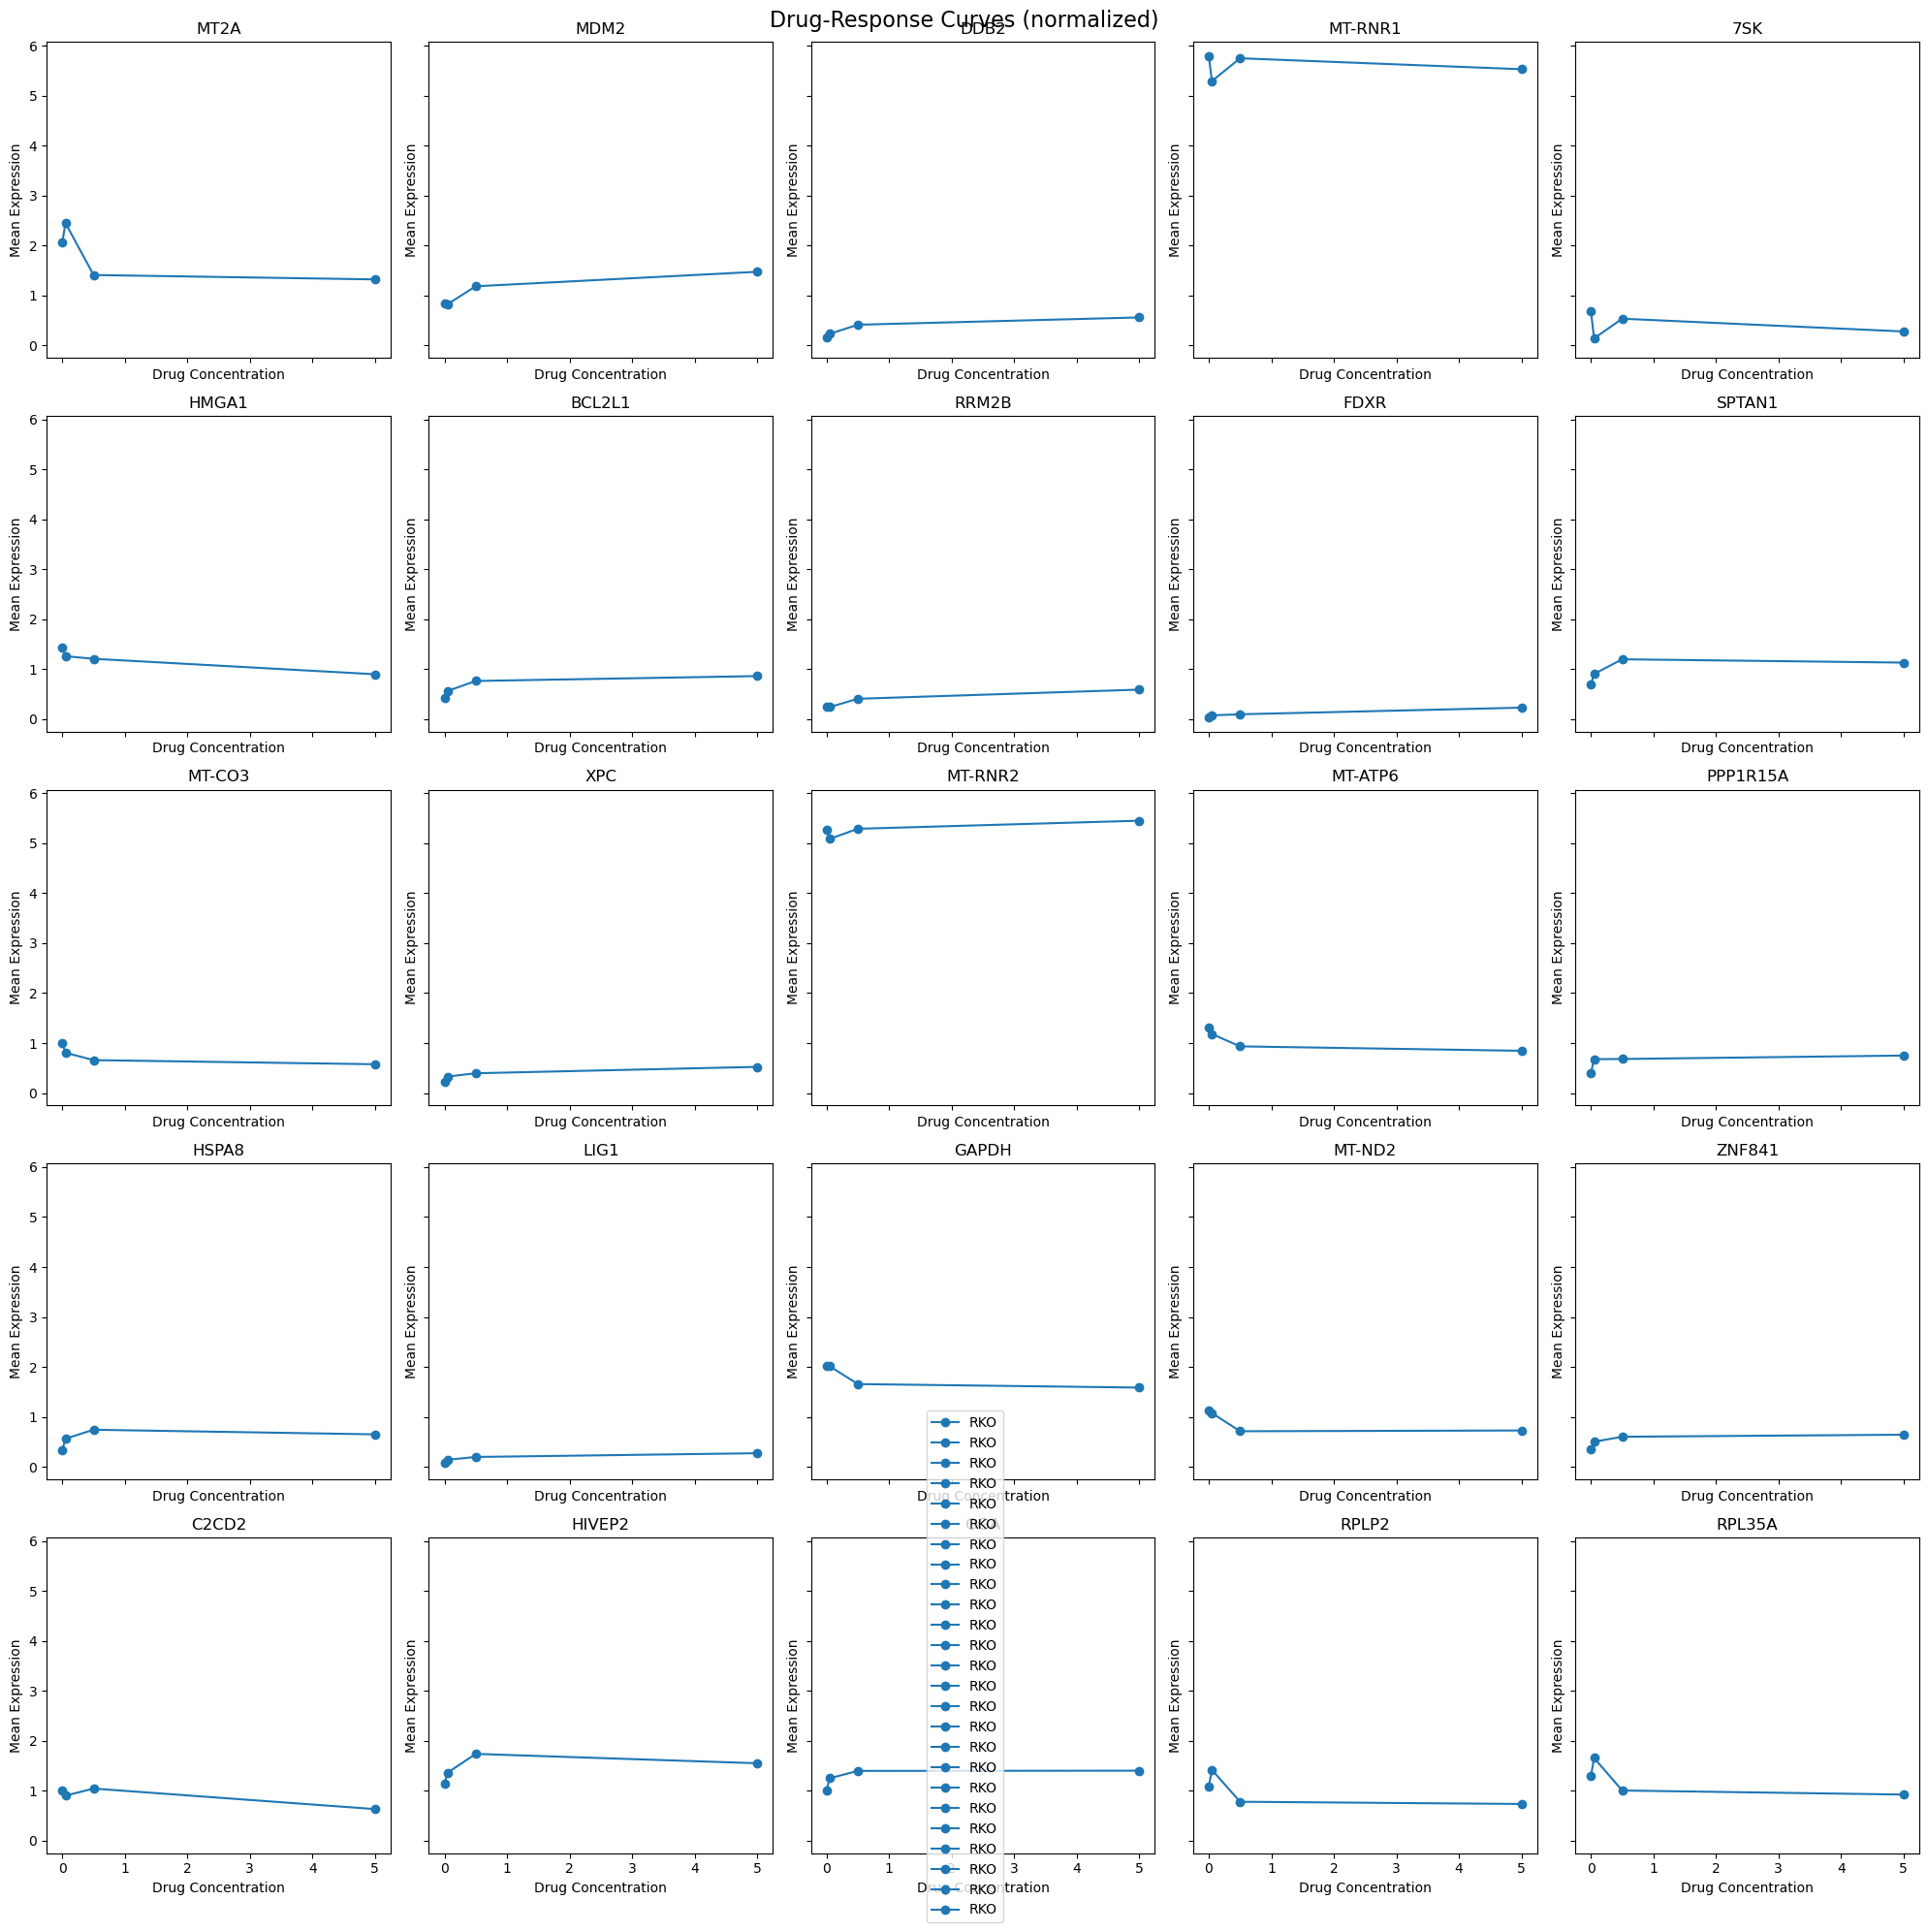

In [36]:
for layer_name, matrix in [("raw", adata.raw.X), ("normalized", adata.X)]:
    share_y = False if layer_name == "raw" else True
    fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=share_y)
    
    for ax, gene in zip(axs.ravel(), top_genes):
        gene_idx = adata.raw.var_names.get_loc(gene) if layer_name == "raw" else adata.var_names.get_loc(gene)

        for cell_line in cell_lines:
            means = []
            for conc in concentrations:
                mask = (adata.obs["drugconc"] == conc) & (adata.obs["cell_name"] == cell_line)
                if mask.sum() == 0:
                    means.append(np.nan)
                    continue
                expr = matrix[mask.to_numpy(), gene_idx]
                means.append(np.asarray(expr.mean()).item())
            
            ax.plot(concentrations, means, marker='o', label=cell_line)

        ax.set_title(gene)
        ax.set_xlabel("Drug Concentration")
        ax.set_ylabel("Mean Expression")

    fig.suptitle(f"Drug-Response Curves ({layer_name})", fontsize=16)
    fig.tight_layout()
    fig.legend(loc='lower center', ncol=len(cell_lines), bbox_to_anchor=(0.5, -0.01))
    plt.savefig(f"drug_response_curves_top25_by_cellline_{layer_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


In [33]:
# Sort and save top/bottom 100
de_df_sorted = de_df.sort_values("pval_adj", ascending=True)

# Save top 100 upregulated genes
de_df_sorted.head(500)["gene"].to_csv("top_100_genes.txt", index=False, header=False)

# Save bottom 100 downregulated genes
de_df_sorted.tail(100)["gene"].to_csv("bottom_100_genes.txt", index=False, header=False)

print("✅ Saved top_100_genes.txt and bottom_100_genes.txt")


✅ Saved top_100_genes.txt and bottom_100_genes.txt


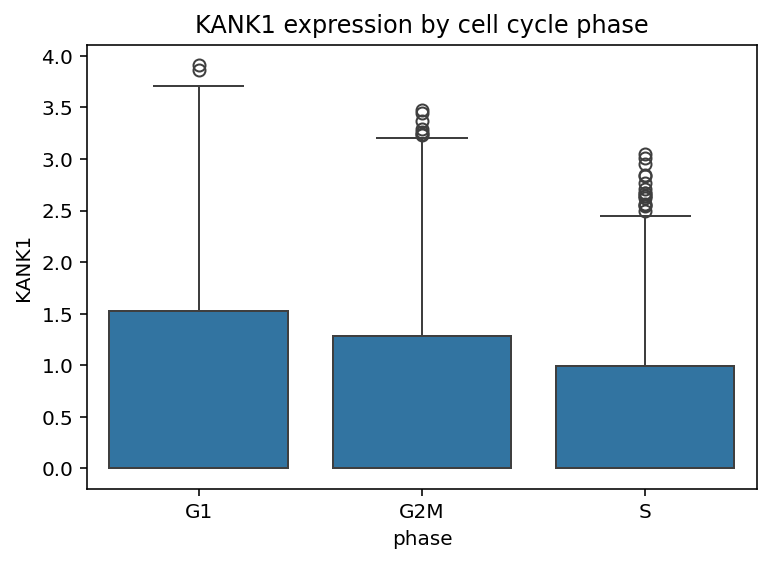

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df = adata.to_df()
df["phase"] = adata.obs["phase"]
sns.boxplot(data=df, x="phase", y="KANK1")
plt.title("KANK1 expression by cell cycle phase")
plt.show()